# TIME SERIES FORECASTING for Tableau Superstore dataset using ARIMA, LSTM and FACEBOOK PROPHET at Sub-Category level

In [116]:
# importing required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.api as sm
from pylab import rcParams
import os, time, sys, math
import missingno as msno 
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.offline as pyoff
import plotly.graph_objs as go
import chart_studio.plotly as py
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from fbprophet import Prophet

# Read Datset
Dataset link: https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls

In [117]:
# Read Dataset
# Dataset link: 
file_path = '/home/sync_ai/Documents/working_folder/Sample_Superstore.xls'
sheet1 = 'Orders'
df = pd.read_excel(file_path, sheet_name = sheet1)
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [118]:
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])
print("\nName of the columns:", df.columns.tolist())
print("\nUnique values\n", df.nunique())

Number of rows:  9994
Number of columns:  21

Name of the columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

Unique values
 Row ID           9994
Order ID         5009
Order Date       1237
Ship Date        1334
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              531
State              49
Postal Code       631
Region              4
Product ID       1862
Category            3
Sub-Category       17
Product Name     1850
Sales            6107
Quantity           14
Discount           12
Profit           7544
dtype: int64


# Data Preprocessing

In [119]:
df.columns = df.columns.str.replace('-', '_')
df.columns = df.columns.str.replace(' ', '_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row_ID         9994 non-null   int64         
 1   Order_ID       9994 non-null   object        
 2   Order_Date     9994 non-null   datetime64[ns]
 3   Ship_Date      9994 non-null   datetime64[ns]
 4   Ship_Mode      9994 non-null   object        
 5   Customer_ID    9994 non-null   object        
 6   Customer_Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal_Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product_ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub_Category   9994 n

We shall analyse the time series of Blinders sales

In [120]:
# Top 10 occuring products ID and 
rep_rows = pd.DataFrame(df['Sub_Category'].value_counts()).reset_index()
rep_rows.columns = ['Sub_Category','count']
print(rep_rows), print("\nUnique Sub-Category Counts: ",df['Sub_Category'].nunique()),print("Total Count: ",rep_rows['count'].sum())

   Sub_Category  count
0       Binders   1523
1         Paper   1370
2   Furnishings    957
3        Phones    889
4       Storage    846
5           Art    796
6   Accessories    775
7        Chairs    617
8    Appliances    466
9        Labels    364
10       Tables    319
11    Envelopes    254
12    Bookcases    228
13    Fasteners    217
14     Supplies    190
15     Machines    115
16      Copiers     68

Unique Sub-Category Counts:  17
Total Count:  9994


(None, None, None)

In [121]:
# converting top 10 product's ID into array
sc_array = rep_rows.head(1)['Sub_Category'].array
sc_array

<PandasArray>
['Binders']
Length: 1, dtype: object

In [122]:
top10 = df.loc[df['Sub_Category'] == 'Binders']
print("Rows: ",top10.shape[0]), print("Columns: ",top10.shape[1]),\
print("\nMIN DATE: ",top10['Order_Date'].min()), print("MAX DATE: ",top10['Order_Date'].max()) 

Rows:  1523
Columns:  21

MIN DATE:  2014-01-04 00:00:00
MAX DATE:  2017-12-30 00:00:00


(None, None, None, None)

In [123]:
cols = ['Row_ID', 'Order_ID', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Postal_Code', 'Region', 'Product_ID', 'Category','Sub_Category' ,'Product_Name', 'Quantity', 'Discount', 'Profit']
top10.drop(cols, axis=1, inplace=True)

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [124]:
top10.reset_index(drop=True, inplace=True)
top10

,Order_Date,Sales
0,2014-06-09,18.504
1,2016-12-05,407.976
2,2015-11-22,2.544
3,2014-08-27,22.720
4,2016-01-16,11.648
...,...,...
1518,2017-12-11,40.200
1519,2017-12-11,735.980
1520,2015-06-28,119.560
1521,2016-12-06,13.376


In [125]:
top10 = top10.groupby([pd.Grouper(key='Order_Date', freq='MS')])['Sales'].sum().reset_index().sort_values('Order_Date')
# freq='W-MON'
print(top10.head(10)), print('\nShape:\n',top10.shape)


  Order_Date      Sales
0 2014-01-01    814.508
1 2014-02-01    339.262
2 2014-03-01   1525.675
3 2014-04-01    985.752
4 2014-05-01   4372.304
5 2014-06-01   4275.793
6 2014-07-01   2934.492
7 2014-08-01   4251.387
8 2014-09-01  12743.616
9 2014-10-01    480.156

Shape:
 (48, 2)


(None, None)

In [126]:
top10 = top10.set_index("Order_Date")
top10.head()

,Sales
Order_Date,
2014-01-01,814.508
2014-02-01,339.262
2014-03-01,1525.675
2014-04-01,985.752
2014-05-01,4372.304


# Blinders - Time series visualization

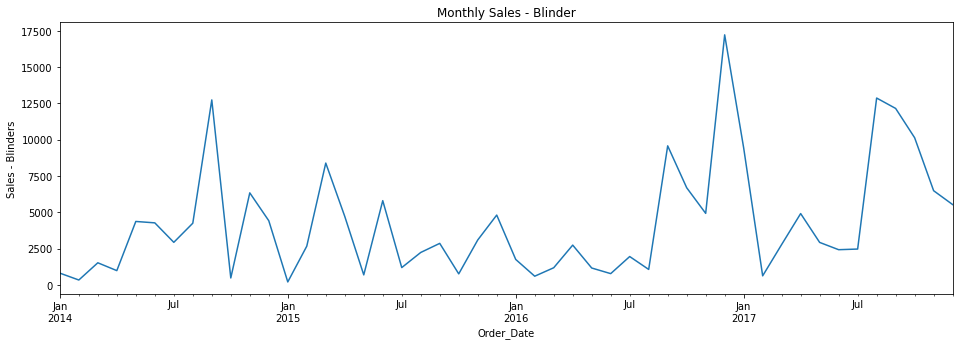

In [127]:
plt_grph = top10['Sales'].plot(figsize = (16,5), title = "Monthly Sales - Blinder")
plt_grph.set(xlabel='Order_Date', ylabel='Sales - Blinders');

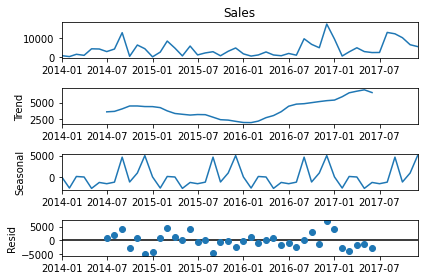

In [128]:
a = seasonal_decompose(top10["Sales"], model = "additive")
a.plot();

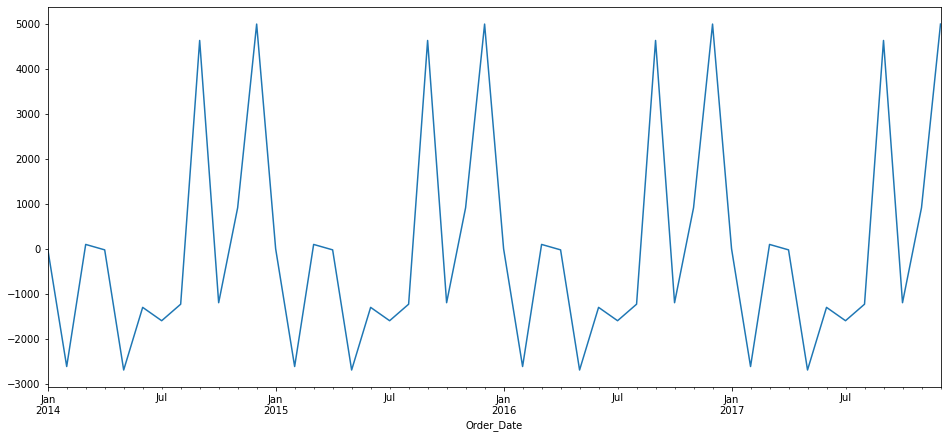

In [129]:
plt.figure(figsize = (16,7))
a.seasonal.plot();

# ARIMA forecast
Let's run auto_arima() function to get best p,q,d,P,D,Q values

In [130]:
from pmdarima import auto_arima   
auto_arima(top10['Sales'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -461.770
Date:                Sun, 19 Jul 2020   AIC                            929.540
Time:                        11:48:05   BIC                            935.153
Sample:                             0   HQIC                           931.661
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4228.0738    997.156      4.240      0.000    2273.683    6182.464
ma.L1          0.3692      0.142      2.597      0.009       0.091       0.648
sigma2      1.325e+07   2.53e+06      5.237      0.000    8.29e+06    1.82e+07
===================================================================================
Ljung-Box (Q):                       31.72   Jarque-Bera (JB):                26.74
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             1.42
Prob(H) (two-sided):                  0.29   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As we can see best arima model chosen by auto_arima() is SARIMAX(0, 0, 1)

# Splitting the dataset into train and test set

In [131]:
train_data = top10[:len(top10)-12]
test_data = top10[len(top10)-12:]

In [132]:
arima_model = SARIMAX(train_data['Sales'], order = (0,0,1), seasonal_order = (1,2,3,12))
arima_result = arima_model.fit()
arima_result.summary()

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      Sales   No. Observations:                   36
Model:             SARIMAX(0, 0, 1)x(1, 2, [1, 2, 3], 12)   Log Likelihood                -118.665
Date:                                    Sun, 19 Jul 2020   AIC                            249.330
Time:                                            11:48:10   BIC                            252.239
Sample:                                        01-01-2014   HQIC                           248.253
                                             - 12-01-2016                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0927      1.371      0.068      0.946      -2.594       2.780
ar.S.L12      -0.9906     12.688     -0.078      0.938     -25.858      23.877
ma.S.L12      -0.6615   3813.913     -0.000      1.000   -7475.793    7474.470
ma.S.L24      -0.6787   3493.272     -0.000      1.000   -6847.367    6846.009
ma.S.L36       0.9827    136.536      0.007      0.994    -266.624     268.589
sigma2      1.286e+07      0.001   1.67e+10      0.000    1.29e+07    1.29e+07
===================================================================================
Ljung-Box (Q):                       11.49   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.40   Prob(JB):                         0.46
Heteroskedasticity (H):               2.25   Skew:                             0.85
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  3e+29. Standard errors may be unstable.
"""

In [133]:
arima_pred = arima_result.predict(start = len(train_data), end = len(top10)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2017-01-01     2366.019664
2017-02-01     2113.676070
2017-03-01     6219.688582
2017-04-01     5053.180794
2017-05-01     2287.312535
2017-06-01     5034.373264
2017-07-01     2837.784378
2017-08-01     3122.268560
2017-09-01    11614.792143
2017-10-01     5461.522156
2017-11-01     6862.654379
2017-12-01    16393.653974
Freq: MS, Name: ARIMA Predictions, dtype: float64

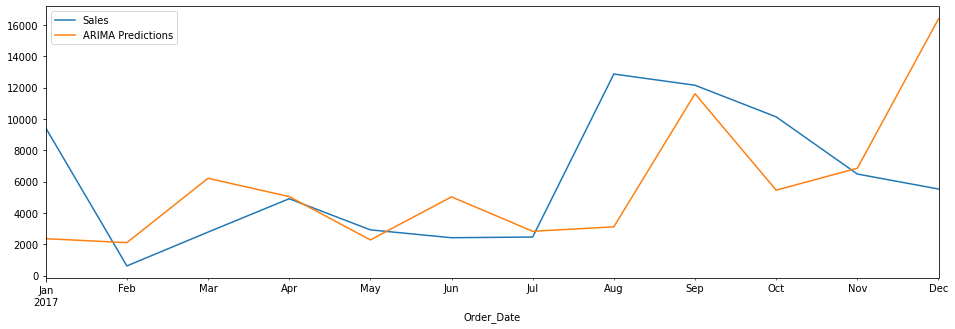

In [134]:
test_data['Sales'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

calculating MSE, MAPE and RMSE values

In [135]:
arima_rmse_error = rmse(test_data['Sales'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Sales'].mean()
arima_mape = np.mean(np.abs((arima_pred - test_data['Sales']) / test_data['Sales'])) * 100
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}\nMAPE: {arima_mape}')

MSE Error: 25553779.84084509
RMSE Error: 5055.074662242398
Mean: 229.85800083049833
MAPE: 75.88467844311094


In [136]:
test_data['ARIMA_Predictions'] = arima_pred
test_data

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Sales,ARIMA_Predictions
Order_Date,,
2017-01-01,9436.823,2366.019664
2017-02-01,626.722,2113.676070
2017-03-01,2785.488,6219.688582
2017-04-01,4915.515,5053.180794
2017-05-01,2928.624,2287.312535
2017-06-01,2427.041,5034.373264
2017-07-01,2471.588,2837.784378
2017-08-01,12873.224,3122.268560
2017-09-01,12157.035,11614.792143


# LSTM forecast
First we will scale our train and test data with MiMaxScaler().
MinMaxScaler features by scaling each feature to a given range. 

In [137]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

TimeseriesGenerator() generates batches of temporal data.

In [138]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [139]:
lstm_model.fit_generator(generator,epochs=220)

Epoch 1/220
24/24 [==============================] - 0s 20ms/step - loss: 0.0563
Epoch 2/220
24/24 [==============================] - 0s 11ms/step - loss: 0.0537
Epoch 3/220
24/24 [==============================] - 0s 9ms/step - loss: 0.0526
Epoch 4/220
24/24 [==============================] - 0s 8ms/step - loss: 0.0508
Epoch 5/220
24/24 [==============================] - 0s 9ms/step - loss: 0.0504
Epoch 6/220
24/24 [==============================] - 0s 8ms/step - loss: 0.0527
Epoch 7/220
24/24 [==============================] - 0s 8ms/step - loss: 0.0535
Epoch 8/220
24/24 [==============================] - 0s 8ms/step - loss: 0.0499
Epoch 9/220
24/24 [==============================] - 0s 14ms/step - loss: 0.0499
Epoch 10/220
24/24 [==============================] - 0s 8ms/step - loss: 0.0489
Epoch 11/220
24/24 [==============================] - 0s 11ms/step - loss: 0.0491
Epoch 12/220
24/24 [==============================] - 0s 8ms/step - loss: 0.0508
Epoch 13/220
24/24 [=============

24/24 [==============================] - 0s 7ms/step - loss: 0.0196
Epoch 103/220
24/24 [==============================] - 0s 12ms/step - loss: 0.0183
Epoch 104/220
24/24 [==============================] - 0s 16ms/step - loss: 0.0203
Epoch 105/220
24/24 [==============================] - 0s 7ms/step - loss: 0.0190
Epoch 106/220
24/24 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 107/220
24/24 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 108/220
24/24 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 109/220
24/24 [==============================] - 0s 9ms/step - loss: 0.0161
Epoch 110/220
24/24 [==============================] - 0s 10ms/step - loss: 0.0169
Epoch 111/220
24/24 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 112/220
24/24 [==============================] - 0s 9ms/step - loss: 0.0170
Epoch 113/220
24/24 [==============================] - 0s 9ms/step - loss: 0.0157
Epoch 114/220
24/24 [======

24/24 [==============================] - 0s 14ms/step - loss: 0.0020
Epoch 202/220
24/24 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 203/220
24/24 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 204/220
24/24 [==============================] - 0s 7ms/step - loss: 7.6481e-04
Epoch 205/220
24/24 [==============================] - 0s 17ms/step - loss: 7.4827e-04
Epoch 206/220
24/24 [==============================] - 0s 17ms/step - loss: 8.0256e-04
Epoch 207/220
24/24 [==============================] - 0s 11ms/step - loss: 6.9834e-04
Epoch 208/220
24/24 [==============================] - 0s 9ms/step - loss: 4.8620e-04
Epoch 209/220
24/24 [==============================] - 0s 8ms/step - loss: 3.6902e-04
Epoch 210/220
24/24 [==============================] - 0s 13ms/step - loss: 5.1617e-04
Epoch 211/220
24/24 [==============================] - 0s 8ms/step - loss: 8.1342e-04
Epoch 212/220
24/24 [==============================] - 0s 8ms/step - loss: 

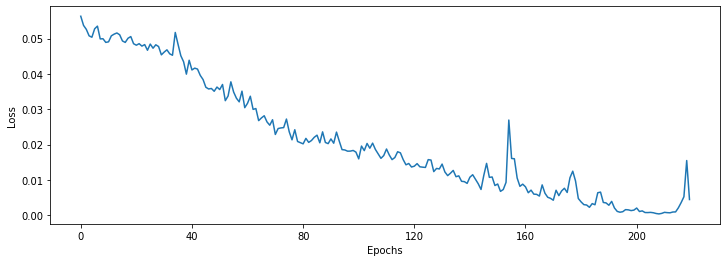

In [140]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,250,40))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [141]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

As we know we scaled our data, we have to inverse it to see true predictions. 

In [142]:
lstm_predictions_scaled

[array([1.3927147], dtype=float32),
 array([1.3389436], dtype=float32),
 array([1.777859], dtype=float32),
 array([0.41057956], dtype=float32),
 array([3.2893543], dtype=float32),
 array([-0.07755901], dtype=float32),
 array([1.2145329], dtype=float32),
 array([0.32457733], dtype=float32),
 array([0.5627424], dtype=float32),
 array([1.0619437], dtype=float32),
 array([0.70307726], dtype=float32),
 array([1.7833569], dtype=float32)]

In [143]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[23908.7307227 ],
       [22993.61730498],
       [30463.37449393],
       [ 7194.09330935],
       [56187.01962709],
       [-1113.37741568],
       [20876.31145889],
       [ 5730.44946874],
       [ 9783.7030946 ],
       [18279.44572796],
       [12172.01592517],
       [30556.94200821]])

Comparing ARIMA and LSTM predicitions

In [144]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

/home/sync_ai/Documents/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Sales,ARIMA_Predictions,LSTM_Predictions
Order_Date,,,
2017-01-01,9436.823,2366.019664,23908.730723
2017-02-01,626.722,2113.676070,22993.617305
2017-03-01,2785.488,6219.688582,30463.374494
2017-04-01,4915.515,5053.180794,7194.093309
2017-05-01,2928.624,2287.312535,56187.019627
2017-06-01,2427.041,5034.373264,-1113.377416
2017-07-01,2471.588,2837.784378,20876.311459
2017-08-01,12873.224,3122.268560,5730.449469
2017-09-01,12157.035,11614.792143,9783.703095


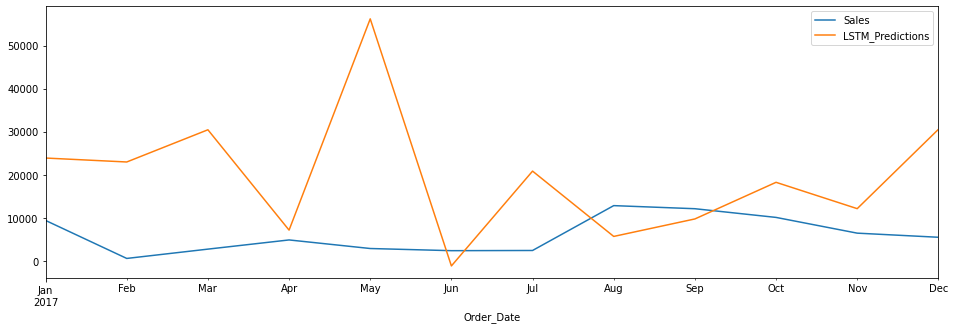

In [145]:
test_data['Sales'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

calculating MSE, MAPE and RMSE values

In [146]:
lstm_rmse_error = rmse(test_data['Sales'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Sales'].mean()
lstm_mape = np.mean(np.abs((test_data["LSTM_Predictions"] - test_data['Sales']) / test_data['Sales'])) * 100
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}\nMAPE: {lstm_mape}')

MSE Error: 454160956.88548553
RMSE Error: 21311.052458418977
Mean: 229.85800083049833
MAPE: 680.5067796150807


# Prophet Forecast
It is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly and daily seasonality plus holiday effects

In [147]:
top10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [148]:
df_pr = top10.copy()
df_pr = top10.reset_index()
df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]

m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)
prophet_pred.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
55,2018-08-01,6622.769438,4006.639010,10797.142051,6622.769307,6622.769566,749.824785,749.824785,749.824785,749.824785,749.824785,749.824785,0.0,0.0,0.0,7372.594223
56,2018-09-01,6694.491125,7967.661385,14876.557428,6694.490966,6694.491279,4632.819272,4632.819272,4632.819272,4632.819272,4632.819272,4632.819272,0.0,0.0,0.0,11327.310397
57,2018-10-01,6763.899209,2931.346121,9699.301674,6763.899022,6763.899385,-347.593508,-347.593508,-347.593508,-347.593508,-347.593508,-347.593508,0.0,0.0,0.0,6416.305701
58,2018-11-01,6835.620896,4941.594928,11901.862148,6835.620683,6835.621098,1482.150101,1482.150101,1482.150101,1482.150101,1482.150101,1482.150101,0.0,0.0,0.0,8317.770997
59,2018-12-01,6905.028981,5975.621942,12801.642389,6905.028730,6905.029214,2484.812729,2484.812729,2484.812729,2484.812729,2484.812729,2484.812729,0.0,0.0,0.0,9389.841709


In [149]:
prophet_pred = pd.DataFrame({"Order_Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Order_Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Order_Date,
2018-01-01,5701.505212
2018-02-01,2910.303362
2018-03-01,6401.049290
2018-04-01,5069.857699
2018-05-01,3813.534980
2018-06-01,5853.176453
2018-07-01,4116.817953
2018-08-01,7372.594223
2018-09-01,11327.310397


/home/sync_ai/Documents/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



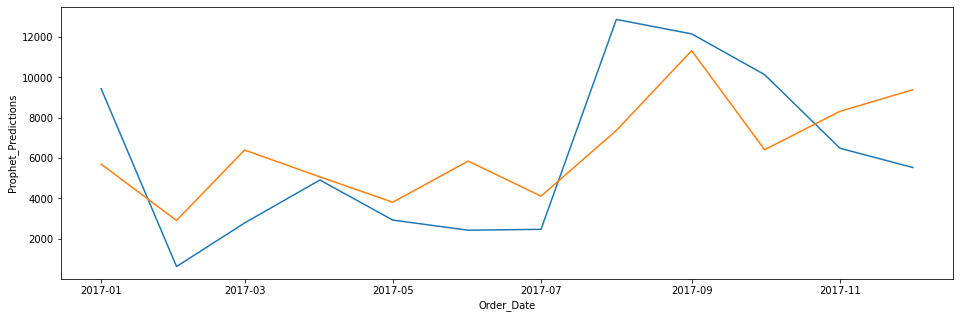

In [150]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Sales"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

calculating MSE, MAPE and RMSE values

In [151]:
prophet_rmse_error = rmse(test_data['Sales'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Sales'].mean()
prophet_mape = np.mean(np.abs((test_data["Prophet_Predictions"] - test_data['Sales']) / test_data['Sales'])) * 100
print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}\nMAPE: {prophet_mape}')

MSE Error: 9207323.671007628
RMSE Error: 3034.357208867741
Mean: 229.85800083049833
MAPE: 79.90614286096474


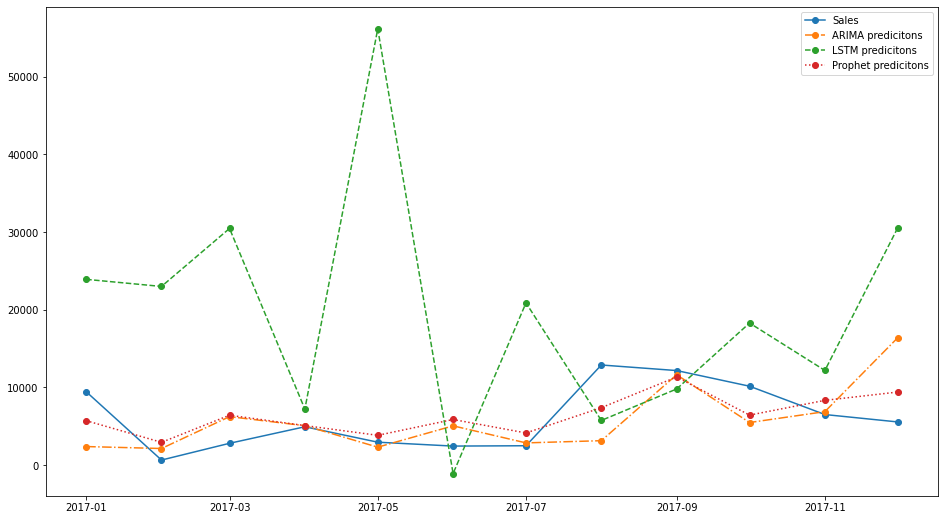

In [152]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
mape = [arima_mape, lstm_mape, prophet_mape]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors, "MAPE" : mape})
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Sales"], linestyle="solid", label='Sales')
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.", label='ARIMA predicitons')
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--", label='LSTM predicitons')
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":", label='Prophet predicitons')
plt.legend()
plt.show()

# Comparing RMSE, MSE and MAPE values 

In [153]:
print(f"Mean: {test_data['Sales'].mean()}")
errors

Mean: 6065.670416666668


,Models,RMSE Errors,MSE Errors,MAPE
0,ARIMA,5055.074662,2.555378e+07,75.884678
1,LSTM,21311.052458,4.541610e+08,680.506780
2,Prophet,3034.357209,9.207324e+06,79.906143


# Comparing ARIMA, LSTM, Prophet Predicitions

In [154]:
test_data

,Sales,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Order_Date,,,,
2017-01-01,9436.823,2366.019664,23908.730723,5701.505212
2017-02-01,626.722,2113.676070,22993.617305,2910.303362
2017-03-01,2785.488,6219.688582,30463.374494,6401.049290
2017-04-01,4915.515,5053.180794,7194.093309,5069.857699
2017-05-01,2928.624,2287.312535,56187.019627,3813.534980
2017-06-01,2427.041,5034.373264,-1113.377416,5853.176453
2017-07-01,2471.588,2837.784378,20876.311459,4116.817953
2017-08-01,12873.224,3122.268560,5730.449469,7372.594223
2017-09-01,12157.035,11614.792143,9783.703095,11327.310397
